# 評価

- トークナイザは`cl-tohoku/bert-large-japanese-v2`固定

In [11]:
import os, sys, glob
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

from sklearn.metrics import precision_score, recall_score
from transformers import BertForSequenceClassification, BertTokenizerFast, BertJapaneseTokenizer, Trainer, TrainingArguments
from transformers import pipeline, Pipeline
from datasets import load_dataset, Dataset

pd.options.display.float_format = "{:.4f}".format


In [ ]:
def load_assets(model_path:str) -> Tuple[Trainer, Dataset]:
  """モデルとデータセットを読み込む
  """
  # tokenizer = BertJapaneseTokenizer.from_pretrained('cl-tohoku/bert-base-japanese-v3')
  tokenizer = BertJapaneseTokenizer.from_pretrained('cl-tohoku/bert-large-japanese-v2')
  dataset = load_dataset('dataset_loader.py', name='sentiment_dataset')

  def _tokenize(batch):
      return tokenizer(batch['text'], padding='max_length', truncation=True)

  # データセットを準備する
  eval_dataset =  dataset['validation'].map(_tokenize, batched=True)
  eval_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

  # モデルを読み込む
  model = BertForSequenceClassification.from_pretrained(model_path, num_labels=3)
  trainer = Trainer(
      model=model
  )
  return trainer, eval_dataset

def predict(sentiment_analyzer:Pipeline, eval_dataset:Dataset) -> Dict[np.ndarray, np.ndarray]:
# def predict(trainer:Trainer, eval_dataset:Dataset) -> Dict[np.ndarray, np.ndarray]:
  # metricsを計算する
  # print(trainer.evaluate(eval_dataset))
  # 予測する
  predictions = sentiment_analyzer.predict(eval_dataset)
  return {'predict_proba':predictions.predictions, 'labels':np.argmax(predictions.predictions, axis=1)}

def evaluate(y_true, y_pred, method='macro', verbose=True):
  precision_macro = precision_score(y_true, y_pred, average=method)
  recall_macro = recall_score(y_true, y_pred, average=method)
  f1 = 2 * (precision_macro * recall_macro) / (precision_macro + recall_macro)
  if verbose:
    print(f'precision_macro: {precision_macro:.3f}\nrecall_macro: {recall_macro:.3f}\nf1: {f1:.3f}')
    display(pd.crosstab(y_true, y_pred, rownames=['True'], colnames=['Predicted'], margins=True))
  return precision_macro, recall_macro, f1

def calculate_f1_score(model_name: str, eval_df: pd.DataFrame):
  prefix = model_name.split('/')[-1]
  prediction_results = predict(*load_assets(model_name))
  eval_df[f'pred_{prefix}'] = prediction_results['labels']
  _, _, f1 = evaluate(eval_df['label'], eval_df[f'pred_{prefix}'])
  return f1

In [264]:
results = {
  '東北大日本語BERT': {
    'base':'-',
    'large':'-',
  },
  'Fine-Tuning-3epochs': {
    'base': '-',
    'large': '-'
  },
  'Fine-Tuning-10epochs': {
    'base': '-',
    'large': '-'   
  },
  'Fine-Tuning-50epochs': {
    'base': '-',
    'large': '-'
  },
  'Fine-Tuning-100epochs': {
    'base': '-',
    'large': '-'
  }
}

In [ ]:
eval_dataset = load_dataset('dataset_loader.py', name='sentiment_dataset')['validation']
print(eval_dataset)
eval_df = eval_dataset.to_pandas()
eval_df.head()

Dataset({
    features: ['text', 'label'],
    num_rows: 325
})


,text,label
0,以前より高くなっている 。,0
1,小岩井の生乳100％ヨーグルトを安くしてくださって嬉しいです これからも買い続けるのでお値段...,1
2,ＱＵＩＣpayで支払いで10%OＦＦにするならば、majicaにチャージして支払いをした場合...,1
3,9月の特売品がたくさん有って良かったです!,1
4,是非気軽にいただける飲食店を増やしてほしいです！フードコートでも店舗でも。,1


In [ ]:
from transformers import pipeline
# ref:https://huggingface.co/docs/transformers/main_classes/pipelines

model = BertForSequenceClassification.from_pretrained('./results', num_labels=3)
tokenizer = BertJapaneseTokenizer.from_pretrained('cl-tohoku/bert-large-japanese-v2')
sentiment_analyzer = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

In [17]:
from pprint import pprint 
pprint(
    [sentiment_analyzer('確かにすばらしいことです。私の注文が届くまでに3週間かかりました'), # 
    sentiment_analyzer('私はサブスクリプションが高額であったとは言いません'),
    sentiment_analyzer('頑丈な造りであることには満足していますが、色には感心していません')])

[[{'label': 'LABEL_1', 'score': 0.9616061449050903}],
 [{'label': 'LABEL_1', 'score': 0.4617416262626648}],
 [{'label': 'LABEL_2', 'score': 0.5467666983604431}]]


## 東北大BERT vs FTBERT

東北大BERT-base

In [265]:
model_name = 'cl-tohoku/bert-base-japanese-v3'
results['東北大日本語BERT']['base'] = calculate_f1_score(model_name=model_name, eval_df=eval_df)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cl-tohoku/bert-base-japanese-v3 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/41 [00:00<?, ?it/s]

precision_macro: 0.291
recall_macro: 0.320
f1: 0.304


Predicted,0,1,2,All
True,,,,
0,2,52,37,91
1,3,88,73,164
2,7,35,28,70
All,12,175,138,325


東北大BERT-large

In [266]:
model_name = 'cl-tohoku/bert-large-japanese-v2'
results['東北大日本語BERT']['large'] = calculate_f1_score(model_name=model_name, eval_df=eval_df)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cl-tohoku/bert-large-japanese-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/41 [00:00<?, ?it/s]

precision_macro: 0.174
recall_macro: 0.326
f1: 0.227


c:\Users\mak1_\Documents\Code\nlp\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Predicted,0,1,All
True,,,
0,85,6,91
1,157,7,164
2,53,17,70
All,295,30,325


FT BERT-base 3 epochs (240 steps)

In [267]:
model_name = 'results_bert-base-japanese-v3_3'
results['Fine-Tuning-3epochs']['base'] = calculate_f1_score(model_name=model_name, eval_df=eval_df)

  0%|          | 0/41 [00:00<?, ?it/s]

precision_macro: 0.758
recall_macro: 0.699
f1: 0.727


Predicted,0,1,2,All
True,,,,
0,71,14,6,91
1,4,155,5,164
2,15,29,26,70
All,90,198,37,325


FT BERT-large 3 epochs (970 steps)

```json
{'eval_loss': 1.0628305673599243,
 'eval_runtime': 58.2609,
 'eval_samples_per_second': 5.561,
 'eval_steps_per_second': 1.39,
 'epoch': 3.0}
```

In [293]:
model_name = 'results_bert-large-japanese-v2_3'
results['Fine-Tuning-3epochs']['large'] = calculate_f1_score(model_name=model_name, eval_df=eval_df)

  0%|          | 0/41 [00:00<?, ?it/s]

precision_macro: 0.168
recall_macro: 0.333
f1: 0.224


c:\Users\mak1_\Documents\Code\nlp\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Predicted,1,All
True,,
0,91,91
1,164,164
2,70,70
All,325,325


FT BERT-base 10 epochs (810 steps)

In [275]:
model_name = 'results_bert-base-japanese-v3_10'
results['Fine-Tuning-10epochs']['base'] = calculate_f1_score(model_name=model_name, eval_df=eval_df)

  0%|          | 0/41 [00:00<?, ?it/s]

precision_macro: 0.720
recall_macro: 0.715
f1: 0.718


Predicted,0,1,2,All
True,,,,
0,71,5,15,91
1,6,142,16,164
2,13,22,35,70
All,90,169,66,325


FT BERT-large 10 epochs (3200 steps)

In [269]:
model_name = 'results_bert-large-japanese-v2_10'
results['Fine-Tuning-10epochs']['large'] = calculate_f1_score(model_name=model_name, eval_df=eval_df)

  0%|          | 0/41 [00:00<?, ?it/s]

precision_macro: 0.168
recall_macro: 0.333
f1: 0.224


c:\Users\mak1_\Documents\Code\nlp\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Predicted,1,All
True,,
0,91,91
1,164,164
2,70,70
All,325,325


FT BERT-base 50 epochs (4050 steps)

In [283]:
model_name = 'results_bert-base-japanese-v3_50'
results['Fine-Tuning-50epochs']['base'] = calculate_f1_score(model_name=model_name, eval_df=eval_df)

  0%|          | 0/41 [00:00<?, ?it/s]

precision_macro: 0.770
recall_macro: 0.739
f1: 0.754


Predicted,0,1,2,All
True,,,,
0,80,8,3,91
1,5,149,10,164
2,17,23,30,70
All,102,180,43,325


FT BERT-base 100 epochs (8100 steps)

```json
{'eval_loss': 2.221827268600464,
 'eval_runtime': 15.5509,
 'eval_samples_per_second': 20.835,
 'eval_steps_per_second': 1.35,
 'epoch': 100.0}
```

In [284]:
model_name = 'results_bert-base-japanese-v3_100'
results['Fine-Tuning-100epochs']['base'] = calculate_f1_score(model_name=model_name, eval_df=eval_df)

  0%|          | 0/41 [00:00<?, ?it/s]

precision_macro: 0.717
recall_macro: 0.694
f1: 0.705


Predicted,0,1,2,All
True,,,,
0,69,10,12,91
1,4,149,11,164
2,14,27,29,70
All,87,186,52,325


### F1スコア

`compute_metrics`: default

|       |   東北大日本語BERT |   Fine-Tuning-3epochs |   Fine-Tuning-10epochs | Fine-Tuning-50epochs   | Fine-Tuning-100epochs   |
|:------|-------------------:|----------------------:|-----------------------:|-----------------------:|------------------------:|
| base  |           0.304489 |              0.66XXXX |               0.67XXXX |     0.70XXXX | 0.708076      |
| large |           0.226644 |              0.223586 |               0.223586 | -                      | -                       |

`compute_metrics`: acc, f1, precision, recall

|       |   東北大日本語BERT |   Fine-Tuning-3epochs |   Fine-Tuning-10epochs | Fine-Tuning-50epochs   | Fine-Tuning-100epochs   |
|:------|-------------------:|----------------------:|-----------------------:|-----------------------:|------------------------:|
| base  |           0.304489 |              0.727328 |               0.717577 |      **0.754010** |      0.705292 |
| large |           0.226644 |              0.223586 |               - | -                      | -                       |

In [288]:
pd.DataFrame.from_dict(results)

,東北大日本語BERT,Fine-Tuning-3epochs,Fine-Tuning-10epochs,Fine-Tuning-50epochs,Fine-Tuning-100epochs
base,0.304489,0.727328,0.717577,0.75401,0.705292
large,0.226644,0.223586,0.223586,-,-


### 学習時損失

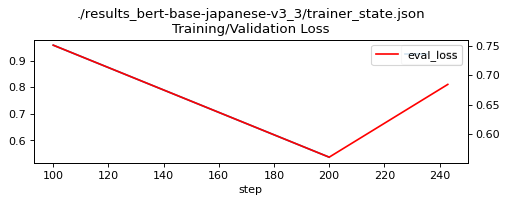

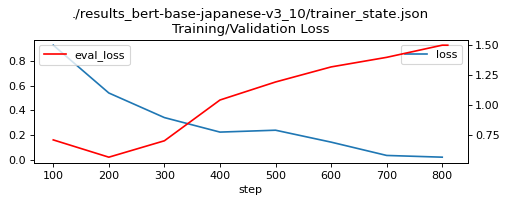

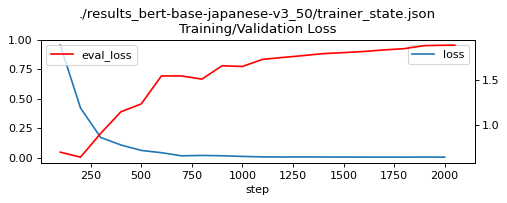

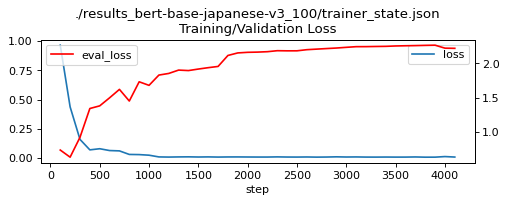

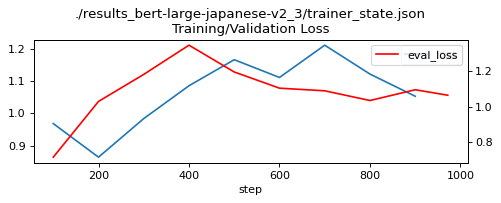

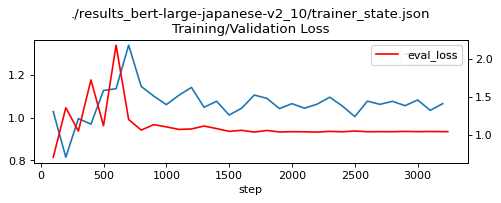

In [292]:
import json

def plot_loss_curve(log_path):

  with open(log_path) as f:
    training_state = json.loads(f.read())
  log_history = training_state['log_history']

  fig, ax = plt.subplots(1, 1, figsize=(7, 2), dpi=80)
  ax2 = ax.twinx()

  train_log_df = pd.DataFrame(log_history).iloc[0::2,:].iloc[:-1]
  eval_log_df = pd.DataFrame(log_history).iloc[1::2,:]

  train_log_df.plot(x='step', y=['loss'], ax=ax)
  eval_log_df.plot(x='step', y=['eval_loss'], ax=ax2, color='red')

  plt.title(f'{log_path}\nTraining/Validation Loss')
  plt.show()

plot_loss_curve(log_path='./results_bert-base-japanese-v3_3/trainer_state.json')
plot_loss_curve(log_path='./results_bert-base-japanese-v3_10/trainer_state.json')
plot_loss_curve(log_path='./results_bert-base-japanese-v3_50/trainer_state.json')
plot_loss_curve(log_path='./results_bert-base-japanese-v3_100/trainer_state.json')
plot_loss_curve(log_path='./results_bert-large-japanese-v2_3/trainer_state.json')
plot_loss_curve(log_path='./results_bert-large-japanese-v2_10/trainer_state.json')

## 感情得点の計算

In [ ]:
model_name = 'results_bert-base-japanese-v3_50'
prediction_results = predict(*load_assets(model_name))

In [389]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def calculate_sentiment_score(probabilities):
    """感情得点を計算する
    感情得点：
        - 肯定的なほど1に近くなり、否定的なほど-1に近くなる。また、中立的なほど0に近くなるような指標。
    Args:
        probabilities (numpy.ndarray): 肯定的、中立的、否定的な確率の配列
            [negative_prob, positive_prob, neutral_prob]
    Returns:
        sentiment_score (float): 感情得点
    
    Examples:
        >>> import numpy as np
        >>> probabilities = np.array([0.1, 0.7, 0.2])
        >>> calculate_sentiment_score(probabilities)
        0.15042637522293034
    """
    # Softmax関数を適用して確率を合計1にする
    probabilities = softmax(probabilities)

    # 感情得点の計算
    negative_prob, positive_prob, neutral_prob = probabilities

    scores = []

    # Implementation 0
    sentiment_score = -1 * negative_prob + 1 * positive_prob + 0 * neutral_prob
    scores.append(sentiment_score)

    # Implementation 1
    sentiment_score = (positive_prob * (1 - neutral_prob)) - (negative_prob * (1 - neutral_prob))
    scores.append(sentiment_score)


    # Implementation 2: 中立的な確率に重みをかける
    weight = 0.25 # 0から1の範囲で調整
    sentiment_score = (positive_prob * (1 - neutral_prob * weight)) - (negative_prob * (1 - neutral_prob * weight))
    scores.append(sentiment_score)

    # return sentiment_score
    return scores

# 例: 肯定的な確率=0.7、中立的な確率=0.2、否定的な確率=0.1の場合
probabilities = np.array([0.1, 0.7, 0.2])

# 感情得点の計算
sentiment_score = calculate_sentiment_score(probabilities)

print(f"The sentiment score is: {sentiment_score}")

The sentiment score is: [0.2093348999756493, 0.15042637522293034, 0.19460776878746955]


In [390]:
eval_df = eval_dataset.to_pandas()[['text', 'label']]
eval_df['pred'] = prediction_results['labels']

# eval_df['sentiment_score'] = np.apply_along_axis(calculate_sentiment_score, 1, prediction_results['predict_proba'])

scores_array = np.apply_along_axis(calculate_sentiment_score, 1, prediction_results['predict_proba'])
eval_df['加重合計'] = scores_array[:, 0]
eval_df['確率の引き算'] = scores_array[:, 1]
eval_df['確率の引き算(ソフト)'] = scores_array[:, 2]

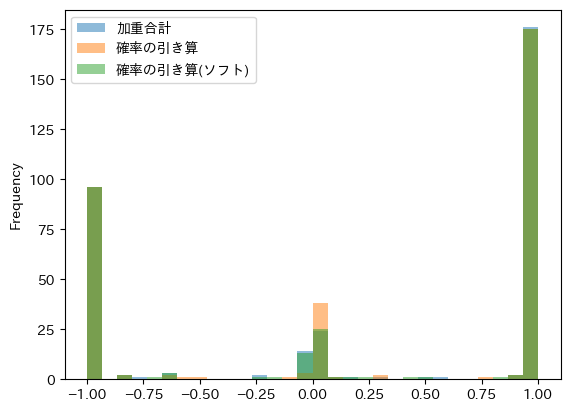

In [392]:
eval_df[['加重合計', '確率の引き算', '確率の引き算(ソフト)']].plot.hist(bins=30, alpha=0.5)
plt.show()

In [393]:
# eval_df.sentiment_score.plot.hist(bins=40)

In [362]:
# 0.9以上 肯定
print('0.9以上 肯定: ', eval_df.query('0.9 <= sentiment_score').shape)
display(eval_df.query('0.9 <= sentiment_score').head())
# 0.5以上 0.9未満 肯定寄り
print('0.5以上 0.9未満 肯定寄り: ', eval_df.query('0.5 <= sentiment_score & sentiment_score < 0.9').shape)
display(eval_df.query('0.5 <= sentiment_score & sentiment_score < 0.9').head())
# 0.1以上 0.5未満 やや肯定より
print('0.1以上 0.5未満 やや肯定より: ', eval_df.query('0.1 <= sentiment_score & sentiment_score < 0.5').shape)
display(eval_df.query('0.1 <= sentiment_score & sentiment_score < 0.5').head())
# -0.1以上 0.1未満 中立
print('-0.1以上 0.1未満 中立: ', eval_df.query('-0.1 <= sentiment_score & sentiment_score < 0.1').shape)
display(eval_df.query('-0.1 <= sentiment_score & sentiment_score < 0.1').head())
# -0.5以上 -0.1未満 やや否定より
print('-0.5以上 -0.1未満 やや否定より: ', eval_df.query('-0.5 <= sentiment_score & sentiment_score < -0.1').shape)
display(eval_df.query('-0.5 <= sentiment_score & sentiment_score < -0.1').head())
# -0.9以上 -0.5未満 否定寄り
print('-0.9以上 -0.5未満 否定寄り: ', eval_df.query('-0.9 <= sentiment_score & sentiment_score < -0.5').shape)
display(eval_df.query('-0.9 <= sentiment_score & sentiment_score < -0.5').head())
# -0.9未満 否定
print('-0.9未満 否定: ', eval_df.query('sentiment_score < -0.9').shape)
display(eval_df.query('sentiment_score < -0.9').head())

0.9以上 肯定:  (177, 4)


,text,label,pred,sentiment_score
1,小岩井の生乳100％ヨーグルトを安くしてくださって嬉しいです これからも買い続けるのでお値段...,1,1,0.9999
2,ＱＵＩＣpayで支払いで10%OＦＦにするならば、majicaにチャージして支払いをした場合...,1,1,0.9996
3,9月の特売品がたくさん有って良かったです!,1,1,0.9999
4,是非気軽にいただける飲食店を増やしてほしいです！フードコートでも店舗でも。,1,1,0.9999
5,従業員の人が親切でした❗。,1,1,0.9999


0.5以上 0.9未満 肯定寄り:  (1, 4)


,text,label,pred,sentiment_score
155,チョコレート菓子が安くて助かってます！チョコレートが無い人生なんて考えられないので 。,1,1,0.8471


0.1以上 0.5未満 やや肯定より:  (4, 4)


,text,label,pred,sentiment_score
98,特に問題ありませんでした。,2,2,0.1499
127,伊勢市のごみ袋、少し高いかなと思います 。,2,2,0.2494
160,さくら大根をいれて！。,1,1,0.4601
232,2.2ミリの太麺パスタを入れて下さい 。,2,1,0.4881


-0.1以上 0.1未満 中立:  (39, 4)


,text,label,pred,sentiment_score
19,クジてなかなか当たら無いのやな～。,0,2,-0.0001
27,本屋さんを置いて。,1,2,0.0000
38,エゴマの葉を置いて欲しいです。,1,2,0.0000
46,特に無し。,2,2,0.0000
59,同じ種類のものはなるべく1箇所にまとめて陳列お願いします。,1,2,0.0269


-0.5以上 -0.1未満 やや否定より:  (2, 4)


,text,label,pred,sentiment_score
198,このくじ、ほんとに当たらない。,0,2,-0.1853
216,店舗によって取扱品が変わる 。,2,2,-0.2143


-0.9以上 -0.5未満 否定寄り:  (6, 4)


,text,label,pred,sentiment_score
77,アイス高い。,0,0,-0.8339
103,キリンアリカリイオン水安くしてください。,0,0,-0.6207
180,レジの行列で通路を塞いでいる場合が多くあり通路が通り難い様に思います(岸和田店) レジ場所移...,2,0,-0.6101
208,一度買って、気に入った品物が２～３日後には売り切れてます その後同じ品物が入荷されなくって残...,0,0,-0.6548
218,レジが混まないように…。,2,0,-0.8185


-0.9未満 否定:  (96, 4)


,text,label,pred,sentiment_score
0,以前より高くなっている 。,0,0,-0.9999
7,店員さんは親切ですが商品について聞きたいことがあつてもだれもいなくて探すのに時間がかかります...,0,0,-0.9999
8,レジが並んでるにかなり。,2,0,-0.9696
9,混んでいた 凄く配達多いですね 。,2,0,-0.9999
12,タメ口の定員さんがいて気分が悪い。,0,0,-0.9999
